# Assignment Week 3 - Group 5

### Cosimo Individual Work


In [1]:
import CambiCosimo_Functions as cc
#Some Functions to make this process easier and cleaner
import importlib
importlib.reload(cc)

<module 'CambiCosimo_Functions' from 'C:\\Users\\ccambi\\Desktop\\NEU\\EAI6000\\CambiCosimo_Functions.py'>

In [2]:
import pandas as pd
import numpy as np
import math as m
from datetime import date
import geopy.distance
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, ElasticNet, LogisticRegression

import time

#import seaborn as sns

In [3]:
filename1 = "fraudTrain.csv"
df_1 = pd.read_csv(filename1)
filename2 = "fraudTest.csv"
df_2 = pd.read_csv(filename2)

fraud_df_all = df_1.append(df_2)

#set to a sample of .xx to get all of the code working correctly, change to 1 for actuall run
fraud_df = fraud_df_all.sample(frac=.25,
                                random_state=12)
#fraud_df=fraud_df_all

In [4]:
#Custom Functions From Craig:
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

def calculate_distance(row):
    coords_1 = (row['lat'], row['long'])
    coords_2 = (row['merch_lat'], row['merch_long'])
    return geopy.distance.geodesic(coords_1, coords_2).km

# Answer from https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
# The answers above are based on the Haversine formula, which assumes the earth is a sphere,
# which results in errors of up to about 0.5% (according to help(geopy.distance)). 
# Vincenty distance uses more accurate ellipsoidal models such as WGS-84, and is implemented in geopy. For example,
def calculate_distance2(row):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(row['lat'])
    lon1 = radians(row['long'])
    lat2 = radians(row['merch_lat'])
    lon2 = radians(row['merch_long'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    print(distance)

In [5]:
# First derive columns
if 'trans_date_trans_time' in fraud_df.columns:
    fraud_df['txn_datetime'] =  pd.to_datetime(fraud_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')

if 'dob' in fraud_df.columns:
    fraud_df['age'] = [calculate_age(d) for d in pd.to_datetime(fraud_df['dob'], format='%Y-%m-%d')]
    
if set(['lat', 'long', 'merch_lat', 'merch_long']).issubset(set(fraud_df.columns)):
     fraud_df['distance'] = [calculate_distance(row) for _, row in fraud_df.iterrows()]
        
fraud_df['hour'] = fraud_df['txn_datetime'].dt.hour
fraud_df['day'] = fraud_df['txn_datetime'].dt.day
fraud_df['month'] = fraud_df['txn_datetime'].dt.month
fraud_df['year'] = fraud_df['txn_datetime'].dt.year

#create a seasons category??
#create a time of day category??

fraud_df['log_amt'] = [m.log(n) for n in fraud_df['amt']] 

In [6]:
#(dataframe, max number of unique values to show)
cc.UniqueValues(fraud_df,30)

Unnamed: 0: 428294 unique values
trans_date_trans_time: 461075 unique values
cc_num: 991 unique values
merchant: 693 unique values
category
['gas_transport' 'kids_pets' 'misc_pos' 'shopping_net' 'home'
 'food_dining' 'entertainment' 'shopping_pos' 'grocery_pos' 'misc_net'
 'health_fitness' 'personal_care' 'grocery_net' 'travel']
amt: 35408 unique values
first: 354 unique values
last: 485 unique values
gender
['F' 'M']
street: 991 unique values
city: 902 unique values
state: 51 unique values
zip: 978 unique values
lat: 976 unique values
long: 976 unique values
city_pop: 886 unique values
job: 495 unique values
dob: 976 unique values
trans_num: 463098 unique values
unix_time: 461076 unique values
merch_lat: 456631 unique values
merch_long: 460522 unique values
is_fraud
[0 1]
txn_datetime: 461075 unique values
age: 82 unique values
distance: 463098 unique values
hour
[11 22  1  5 17 23 12 21 13 16 15 14  2 10 20  9  4  3  6 19  8  7 18  0]
day: 31 unique values
month
[ 3  4  8 12  2  1 10

In [7]:
#create target lables
#target will be a binary classification variable for logistic regression: is_fraud
fraud_df['Target'] = fraud_df['is_fraud']

In [8]:
#Review the prevalence of the positive class for target
print('Prevalence of the positive class for Target: {:.3f}'.format(cc.calc_prevalence(fraud_df['Target'].values)))

Prevalence of the positive class for Target: 0.005


In [9]:
#create a list to hold our categorical columns and one to hold our numerical columns
cat_col = ['category','gender']
num_col = ['age','city_pop','distance','amt','month','hour','day','year']

In [10]:
#make sure there are no missing values 
print(fraud_df[cat_col].isnull().sum().sort_values(ascending = False).head(50))
print(fraud_df[num_col].isnull().sum().sort_values(ascending = False).head(50))

gender      0
category    0
dtype: int64
year        0
day         0
hour        0
month       0
amt         0
distance    0
city_pop    0
age         0
dtype: int64


In [11]:
#In order for categorical columns to work we have to one hot encode them
if len(cat_col)>0: 
    cat_onehotencode = pd.get_dummies(fraud_df[cat_col],drop_first = True)
    cat_col_onehotencode = list(cat_onehotencode.columns)
    fraud_df = pd.concat([fraud_df,cat_onehotencode], axis = 1)

else:
    cat_col_onehotencode = []

In [12]:
input_col = (num_col + cat_col_onehotencode)

In [13]:
#check for colinearity and create a new input column list for the reduced set
input_col_reduced = cc.auto_vif(fraud_df[input_col],7)

Removed column 'year' with a 53.047709790594894 VIF.
Final VIF DF
                  variables       VIF
2                  distance  6.823275
0                       age  6.640844
5                      hour  6.589325
4                     month  4.927764
6                       day  3.941152
12            category_home  2.078092
13       category_kids_pets  1.998311
8    category_gas_transport  1.923728
10     category_grocery_pos  1.881548
18    category_shopping_pos  1.816488
16   category_personal_care  1.795751
20                 gender_M  1.787674
11  category_health_fitness  1.743165
7      category_food_dining  1.736453
17    category_shopping_net  1.673539
15        category_misc_pos  1.528591
14        category_misc_net  1.421283
19          category_travel  1.366509
9      category_grocery_net  1.283685
3                       amt  1.250984
1                  city_pop  1.090991


In [14]:
print('Total number of features: {}'.format(len(num_col + cat_col_onehotencode)))
print('Numerical Features: {}'.format(len(num_col)))
print('Categorical Features: {}'.format(len(cat_col_onehotencode)))
print('Total number of features after coliniarity reduction: {}'.format(len(input_col_reduced)))

Total number of features: 22
Numerical Features: 8
Categorical Features: 14
Total number of features after coliniarity reduction: 21


In [15]:
#build Training/Validation/Test Samples 
#(dataframe,randomseed,train split)
train_ub,valid,test = cc.Train_Valid_Test_Split(fraud_df[input_col +['Target']],12,.7)

In [16]:
#balance the data set via Smote
train = cc.balance_train_df(train_ub,'Sub','Target')

#Possible alternative is to underdampe the data
#train = cc.balance_train_df(train_ub,'Sub','Target')

Balance Method Selected is  Sub
Train balanced prevalence(n = 3,384):0.500


In [17]:
# create the X and y matrices for models
X_train = train[input_col].values
X_train_rd = train[input_col_reduced].values
X_valid = valid[input_col].values
X_valid_rd = valid[input_col_reduced].values
X_test = test[input_col].values
X_test_rd = test[input_col_reduced].values

y_train = train['Target'].values
y_valid = valid['Target'].values
y_test = test['Target'].values

In [18]:
#This creates scalars in order to scale the data so each variable is of similar size.
#Use the unbalenced data set
scaler  = StandardScaler()
scaler.fit(train_ub[input_col].values)

scaler_reduced  = StandardScaler()
scaler_reduced.fit(train_ub[input_col_reduced].values)

# transform our data matrices - this applies our scalar and scales the matrices for training and validation data
X_train_tf = scaler.transform(X_train)
X_train_rd_tf = scaler_reduced.transform(X_train_rd)
X_valid_tf = scaler.transform(X_valid)
X_valid_rd_tf = scaler_reduced.transform(X_valid_rd)
X_test_tf = scaler.transform(X_test)
X_test_rd_tf = scaler_reduced.transform(X_test_rd)

# Start Modeling

In [19]:
#Scoring used for cross validation
auc_scoring = make_scorer(roc_auc_score)

# Logistic Regression

In [20]:
#Create a Baseline Model
lr=LogisticRegression(random_state = 12)

lr.fit(X_train_rd, y_train)

y_train_preds = lr.predict_proba(X_train_rd_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_rd_tf)[:,1]

print('Baseline Logistic Regression')
lr_train_base_auc = roc_auc_score(y_train, y_train_preds)
lr_valid_base_auc = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:{:.3f}'.format(lr_train_base_auc))
print('Validation AUC:{:.3f}'.format(lr_valid_base_auc))

Baseline Logistic Regression
Training AUC:0.773
Validation AUC:0.772


In [21]:
#help(LogisticRegression)
#lr.get_params()

In [22]:
#Create grid Optimized Model

C = [0.002,0.02,1.2,2,20]
class_weight = [None]
dual = [False,True]
fit_intercept = [False,True]
intercept_scaling = [1]
l1_ratio = [None]
max_iter = [50,100,250]
multi_class = ['auto']
n_jobs = [-1]
random_state = [12]
penalty = ['l1', 'l2', 'elasticnet']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
tol = [0.001,0.0001,0.00001]
verbose = [1]
warm_start = [False,True]

#param_grid

param_grid_lr = {'C': C,
 'class_weight': class_weight,
 'dual': dual,
 'fit_intercept': fit_intercept,
 'intercept_scaling': intercept_scaling,
 'l1_ratio': l1_ratio,
 'max_iter': max_iter,
 'multi_class': multi_class,
 'n_jobs': n_jobs,
 'penalty': penalty,
 'random_state': random_state,
 'solver': solver,
 'tol': tol,
 'verbose': verbose,
 'warm_start': warm_start}

print(param_grid_lr)


{'C': [0.002, 0.02, 1.2, 2, 20], 'class_weight': [None], 'dual': [False, True], 'fit_intercept': [False, True], 'intercept_scaling': [1], 'l1_ratio': [None], 'max_iter': [50, 100, 250], 'multi_class': ['auto'], 'n_jobs': [-1], 'penalty': ['l1', 'l2', 'elasticnet'], 'random_state': [12], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'tol': [0.001, 0.0001, 1e-05], 'verbose': [1], 'warm_start': [False, True]}


In [23]:
# create the cross-validation by grid method
lr_grid = GridSearchCV(estimator = lr, param_grid = param_grid_lr, 
                            cv = 5, scoring=auc_scoring,verbose = 3, n_jobs = -1, 
                            error_score=0)


# fit the random search model (this will take a few minutes)
t1 = time.time()
lr_grid.fit(X_train_rd_tf, y_train)
t2 = time.time()
print('Elapsed Time:',(t2-t1))

print('Best Parameters:',lr_grid.best_params_)

Fitting 5 folds for each of 5400 candidates, totalling 27000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 3416 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 6258 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 9096 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 12666 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 16224 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 19072 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 22696 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 27000 out of 27000 | elapsed:  2.8min finished


convergence after 7 epochs took 0 seconds
Elapsed Time: 167.09468698501587
Best Parameters: {'C': 0.002, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 50, 'multi_class': 'auto', 'n_jobs': -1, 'penalty': 'l1', 'random_state': 12, 'solver': 'saga', 'tol': 0.001, 'verbose': 1, 'warm_start': False}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [24]:
print('Optimized Logistic Regression')
y_train_preds_grid = lr_grid.best_estimator_.predict_proba(X_train_rd_tf)[:,1]
y_valid_preds_grid = lr_grid.best_estimator_.predict_proba(X_valid_rd_tf)[:,1]

lr_train_opt_auc = roc_auc_score(y_train, y_train_preds_grid)
lr_valid_opt_auc = roc_auc_score(y_valid, y_valid_preds_grid)

print('Training AUC:{:.3f}'.format(lr_train_opt_auc))
print('Validation AUC:{:.3f}'.format(lr_valid_opt_auc))

Optimized Logistic Regression
Training AUC:0.840
Validation AUC:0.805


## Decision Tree

In [25]:
#Create a Baseline Model
dt=DecisionTreeClassifier(random_state = 12)

dt.fit(X_train, y_train)

y_train_preds = dt.predict_proba(X_train_tf)[:,1]
y_valid_preds = dt.predict_proba(X_valid_tf)[:,1]

print('Baseline Decision Tree')
dt_train_base_auc = roc_auc_score(y_train, y_train_preds)
dt_valid_base_auc = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:{:.3f}'.format(dt_train_base_auc))
print('Validation AUC:{:.3f}'.format(dt_valid_base_auc))


Baseline Decision Tree
Training AUC:0.482
Validation AUC:0.495


In [26]:
#help(DecisionTreeClassifier)
#dt_sub.get_params()

In [27]:
#Create Optimized Model

ccp_alpha=[0.0,0.2]
class_weight=[None]
criterion=['gini','entropy']
max_depth=[None]
max_features=["auto", "sqrt", "log2","none"]
max_leaf_nodes=[None]
min_impurity_decrease=[0.0]
min_impurity_split=[None]
min_samples_leaf=[1,2,10]
min_samples_split=[1,2,10]
min_weight_fraction_leaf=[0.0,0.1,0.25]
random_state=[12]
splitter=['best','random']

#param_grid

param_grid_dt = {'ccp_alpha': ccp_alpha,
 'class_weight': class_weight,
 'criterion': criterion,
 'max_depth': max_depth,
 'max_features': max_features,
 'max_leaf_nodes': max_leaf_nodes,
 'min_impurity_decrease': min_impurity_decrease,
 'min_impurity_split': min_impurity_split,
 'min_samples_leaf': min_samples_leaf,
 'min_samples_split': min_samples_split,
 'min_weight_fraction_leaf': min_weight_fraction_leaf,
 'random_state': random_state,
 'splitter': splitter}

print(param_grid_dt)

{'ccp_alpha': [0.0, 0.2], 'class_weight': [None], 'criterion': ['gini', 'entropy'], 'max_depth': [None], 'max_features': ['auto', 'sqrt', 'log2', 'none'], 'max_leaf_nodes': [None], 'min_impurity_decrease': [0.0], 'min_impurity_split': [None], 'min_samples_leaf': [1, 2, 10], 'min_samples_split': [1, 2, 10], 'min_weight_fraction_leaf': [0.0, 0.1, 0.25], 'random_state': [12], 'splitter': ['best', 'random']}


In [28]:
# create the cross-validation by grid method
dt_grid = GridSearchCV(estimator = dt, param_grid = param_grid_dt, 
                            cv = 5, scoring=auc_scoring,verbose = 1, n_jobs = -1, 
                            error_score=0)

# fit the random search model (this will take a few minutes)
t1 = time.time()
dt_grid.fit(X_train_tf, y_train)
t2 = time.time()
print('Elapsed Time:',(t2-t1))

print('Best Parameters:',dt_grid.best_params_)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    7.9s


Elapsed Time: 10.714024543762207
Best Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'random_state': 12, 'splitter': 'best'}


[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:   10.5s finished


In [29]:
print('Optimized Decision Tree')
y_train_preds_grid = dt_grid.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_grid = dt_grid.best_estimator_.predict_proba(X_valid_tf)[:,1]

dt_train_opt_auc = roc_auc_score(y_train, y_train_preds_grid)
dt_valid_opt_auc = roc_auc_score(y_valid, y_valid_preds_grid)

print('Training AUC:{:.3f}'.format(dt_train_opt_auc))
print('Validation AUC:{:.3f}'.format(dt_valid_opt_auc))

Optimized Decision Tree
Training AUC:0.995
Validation AUC:0.926


## Random Forest

In [30]:
#Create a Baseline Model
rf=RandomForestClassifier(random_state = 12)

rf.fit(X_train, y_train)

y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Baseline Random Forest')
rf_train_base_auc = roc_auc_score(y_train, y_train_preds)
rf_valid_base_auc = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:{:.3f}'.format(rf_train_base_auc))
print('Validation AUC:{:.3f}'.format(rf_valid_base_auc))

Baseline Random Forest
Training AUC:0.353
Validation AUC:0.366


In [31]:
#help(RandomForestClassifier)
#rf_sub.get_params()

In [32]:
#Create Optimized Model

bootstrap=[True,False]
ccp_alpha=[0.0,0.2]
class_weight=[None]
criterion=['gini','entropy']
max_depth=[None]
max_features=["auto", "sqrt", "log2","none"]
max_leaf_nodes=[None]
max_samples=[0,.5,1]
min_impurity_decrease=[0.0]
min_impurity_split=[None]
min_samples_leaf=[1,2,10]
min_samples_split=[1,2,10]
n_estimators=[10,100,250]#,1000]
n_jobs=[-1]
oob_score=[True,False]
random_state=[12]
verbose=[1]
warm_start=[True,False]

#param_grid

param_grid_rf = {'bootstrap': bootstrap,
 'ccp_alpha': ccp_alpha,
 'class_weight': class_weight,
 'criterion': criterion,
 'max_depth': max_depth,
 'max_features': max_features,
 'max_leaf_nodes': max_leaf_nodes,
 'max_samples': max_samples,
 'min_impurity_decrease': min_impurity_decrease,
 'min_impurity_split': min_impurity_split,
 'min_samples_leaf': min_samples_leaf,
 'min_samples_split': min_samples_split,
 'min_weight_fraction_leaf': min_weight_fraction_leaf,
 'n_estimators': n_estimators,
 'n_jobs': n_jobs,
 'oob_score': oob_score,
 'random_state': random_state,
 'verbose': verbose,
 'warm_start': warm_start}

print(param_grid_rf)

{'bootstrap': [True, False], 'ccp_alpha': [0.0, 0.2], 'class_weight': [None], 'criterion': ['gini', 'entropy'], 'max_depth': [None], 'max_features': ['auto', 'sqrt', 'log2', 'none'], 'max_leaf_nodes': [None], 'max_samples': [0, 0.5, 1], 'min_impurity_decrease': [0.0], 'min_impurity_split': [None], 'min_samples_leaf': [1, 2, 10], 'min_samples_split': [1, 2, 10], 'min_weight_fraction_leaf': [0.0, 0.1, 0.25], 'n_estimators': [10, 100, 250], 'n_jobs': [-1], 'oob_score': [True, False], 'random_state': [12], 'verbose': [1], 'warm_start': [True, False]}


In [33]:

# create the cross-validation by grid method
#rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid_rf, 
#                            cv = 2, scoring=auc_scoring,verbose = 1, n_jobs = -1, #changed cv to 2 due to time
#                            error_score=0)

#Random grid search used for time constraints:

rf_rand = RandomizedSearchCV(estimator = rf, param_distributions = param_grid_rf, 
                            n_iter = 1000, cv = 5, scoring=auc_scoring,verbose = 1, n_jobs = -1,
                            error_score=0, random_state=12)
        

# fit the random search model (this will take a few minutes)
t1 = time.time()
rf_rand.fit(X_train_tf, y_train)
t2 = time.time()
print('Elapsed Time:',(t2-t1))

print('Best Parameters:',rf_rand.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 628 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 1113 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1754 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2512 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3250 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4352 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4985 out of 5000 | elapsed:  5.2min remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  5.3min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s


Elapsed Time: 318.0159420967102
Best Parameters: {'warm_start': False, 'verbose': 1, 'random_state': 12, 'oob_score': False, 'n_jobs': -1, 'n_estimators': 250, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_split': None, 'min_impurity_decrease': 0.0, 'max_samples': 1, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini', 'class_weight': None, 'ccp_alpha': 0.0, 'bootstrap': False}


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished


In [34]:
print('Optimized Random Forest')
y_train_preds_rand = rf_rand.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_rand = rf_rand.best_estimator_.predict_proba(X_valid_tf)[:,1]

rf_train_opt_auc = roc_auc_score(y_train, y_train_preds_rand)
rf_valid_opt_auc = roc_auc_score(y_valid, y_valid_preds_rand)

print('Training AUC:{:.3f}'.format(rf_train_opt_auc))
print('Validation AUC:{:.3f}'.format(rf_valid_opt_auc))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


Optimized Random Forest


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s


Training AUC:1.000
Validation AUC:0.991


[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.9s finished


## Gradient Boosting Classifier

In [35]:
#Create a Baseline Model
gbc=GradientBoostingClassifier(random_state = 12)

gbc.fit(X_train, y_train)

y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Baseline Gradient Boosting Classifier')
gbc_train_base_auc = roc_auc_score(y_train, y_train_preds)
gbc_valid_base_auc = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:{:.3f}'.format(gbc_train_base_auc))
print('Validation AUC:{:.3f}'.format(gbc_valid_base_auc))

Baseline Gradient Boosting Classifier
Training AUC:0.433
Validation AUC:0.453


## Learning Curves to help with hypertuning parameters

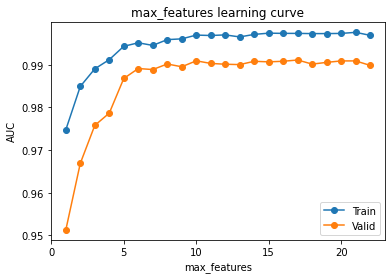

In [36]:
#learning curves
max_features = np.arange(1,23,1)

train_aucs = np.zeros(len(max_features))
valid_aucs = np.zeros(len(max_features))

for jj in range(len(max_features)):
    max_feature = max_features[jj]
    # fit model
    gbc =GradientBoostingClassifier(max_features=max_feature, random_state=12)
    gbc.fit(X_train_tf, y_train)
    
    # get predictions
    y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
    y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

    # calculate auc
    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)

    # save aucs
    train_aucs[jj] = auc_train
    valid_aucs[jj] = auc_valid

plt.plot(max_features, train_aucs,'o-',label = 'Train')
plt.plot(max_features, valid_aucs,'o-',label = 'Valid')

plt.xlabel('max_features')
plt.title('max_features learning curve')
plt.ylabel('AUC')
plt.legend()
plt.show()

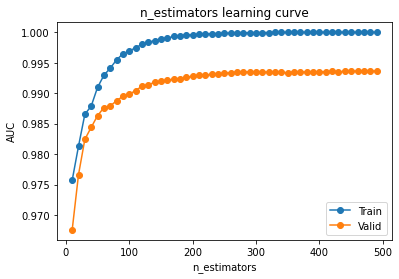

In [37]:
#learning curves
n_estimators = np.arange(10,500,10)

train_aucs = np.zeros(len(n_estimators))
valid_aucs = np.zeros(len(n_estimators))

for jj in range(len(n_estimators)):
    n_estimator = n_estimators[jj]
    print
    # fit model
    gbc =GradientBoostingClassifier(n_estimators=n_estimator, random_state=12)
    gbc.fit(X_train_tf, y_train)
    
    # get predictions
    y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
    y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

    # calculate auc
    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)

    # save aucs
    train_aucs[jj] = auc_train
    valid_aucs[jj] = auc_valid

plt.plot(n_estimators, train_aucs,'o-',label = 'Train')
plt.plot(n_estimators, valid_aucs,'o-',label = 'Valid')

plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.title('n_estimators learning curve')
plt.legend()
plt.show()

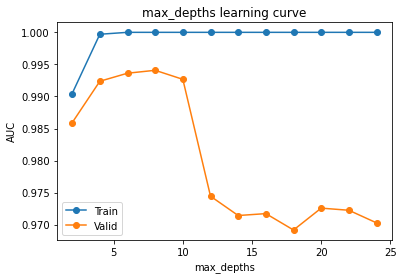

In [38]:
#learning curves
max_depths = np.arange(2,26,2)

train_aucs = np.zeros(len(max_depths))
valid_aucs = np.zeros(len(max_depths))

for jj in range(len(max_depths)):
    max_depth = max_depths[jj]
    # fit model
    gbc =GradientBoostingClassifier(max_depth=max_depth, random_state=12)
    gbc.fit(X_train_tf, y_train)
    
    # get predictions
    y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
    y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

    # calculate auc
    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)

    # save aucs
    train_aucs[jj] = auc_train
    valid_aucs[jj] = auc_valid

plt.plot(max_depths, train_aucs,'o-',label = 'Train')
plt.plot(max_depths, valid_aucs,'o-',label = 'Valid')

plt.xlabel('max_depths')
plt.title('max_depths learning curve')
plt.ylabel('AUC')
plt.legend()
plt.show()

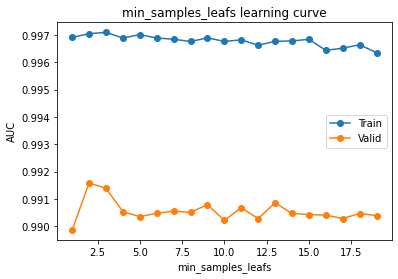

In [39]:
#learning curves
min_samples_leafs = np.arange(1,20,1)

train_aucs = np.zeros(len(min_samples_leafs))
valid_aucs = np.zeros(len(min_samples_leafs))

for jj in range(len(min_samples_leafs)):
    min_samples_leaf = min_samples_leafs[jj]
    # fit model
    gbc =GradientBoostingClassifier(min_samples_leaf=min_samples_leaf, random_state=12)
    gbc.fit(X_train_tf, y_train)
    
    # get predictions
    y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
    y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

    # calculate auc
    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)

    # save aucs
    train_aucs[jj] = auc_train
    valid_aucs[jj] = auc_valid

plt.plot(min_samples_leafs, train_aucs,'o-',label = 'Train')
plt.plot(min_samples_leafs, valid_aucs,'o-',label = 'Valid')

plt.xlabel('min_samples_leafs')
plt.title('min_samples_leafs learning curve')
plt.ylabel('AUC')
plt.legend()
plt.show()

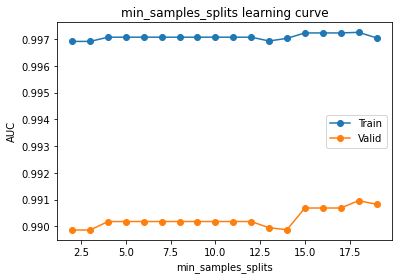

In [40]:
#learning curves
min_samples_splits = np.arange(2,20,1)

train_aucs = np.zeros(len(min_samples_splits))
valid_aucs = np.zeros(len(min_samples_splits))

for jj in range(len(min_samples_splits)):
    min_samples_split = min_samples_splits[jj]
    # fit model
    gbc =GradientBoostingClassifier(min_samples_split=min_samples_split, random_state=12)
    gbc.fit(X_train_tf, y_train)
    
    # get predictions
    y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
    y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

    # calculate auc
    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)

    # save aucs
    train_aucs[jj] = auc_train
    valid_aucs[jj] = auc_valid

plt.plot(min_samples_splits, train_aucs,'o-',label = 'Train')
plt.plot(min_samples_splits, valid_aucs,'o-',label = 'Valid')

plt.xlabel('min_samples_splits')
plt.title('min_samples_splits learning curve')
plt.ylabel('AUC')
plt.legend()
plt.show()

## Grid Search

In [41]:
#Create Optimized Model

ccp_alpha= [0.0,0,5,1]
criterion = ['friedman_mse','mse','mae']
init= ['zero']
learning_rate = [0.01,0.05,0.1,0.25]
loss = ['deviance', 'exponential']
max_depth = [4,6,8,10,12]
max_features = ['auto','log2',8]
max_leaf_nodes = [10,None]
min_impurity_decrease = [0.0]
min_impurity_split = [None]
min_samples_leaf = [1,2,3,4]
min_samples_split = [2]
min_weight_fraction_leaf = [0.0]
n_estimators = range(150,501,50)
n_iter_no_change = [None]
random_state = [12]
subsample = [0.75,1.0]
tol = [0.0001,0.001,0.01]
validation_fraction = [0.1,0.25]
verbose = [1]
warm_start = [True,False]
    
# param grid
param_grid_gbc = {'ccp_alpha' : ccp_alpha,
                    'criterion': criterion,
                    'init': init,
                    'learning_rate': learning_rate,
                    'loss': loss,
                    'max_depth': max_depth,
                    'max_features': max_features,
                    'max_leaf_nodes': max_leaf_nodes,
                    'min_impurity_decrease': min_impurity_decrease,
                    'min_impurity_split': min_impurity_split,
                    'min_samples_leaf': min_samples_leaf,
                    'min_samples_split': min_samples_split,
                    'n_estimators': n_estimators,
                    'n_iter_no_change': n_iter_no_change,
                    'random_state': random_state,
                    'subsample': subsample,
                    'tol': tol,
                    'validation_fraction': validation_fraction,
                    'verbose': verbose,
                    'warm_start': warm_start
                    }

print(param_grid_gbc)

{'ccp_alpha': [0.0, 0, 5, 1], 'criterion': ['friedman_mse', 'mse', 'mae'], 'init': ['zero'], 'learning_rate': [0.01, 0.05, 0.1, 0.25], 'loss': ['deviance', 'exponential'], 'max_depth': [4, 6, 8, 10, 12], 'max_features': ['auto', 'log2', 8], 'max_leaf_nodes': [10, None], 'min_impurity_decrease': [0.0], 'min_impurity_split': [None], 'min_samples_leaf': [1, 2, 3, 4], 'min_samples_split': [2], 'n_estimators': range(150, 501, 50), 'n_iter_no_change': [None], 'random_state': [12], 'subsample': [0.75, 1.0], 'tol': [0.0001, 0.001, 0.01], 'validation_fraction': [0.1, 0.25], 'verbose': [1], 'warm_start': [True, False]}


In [42]:
# create the cross-validation by grid method
#gbc_grid = GridSearchCV(estimator = gbc, param_grid = param_grid_gbc, 
#                            cv = 2, scoring=auc_scoring,verbose = 1, n_jobs = -1, #changed cv to 2 due to time
#                            error_score=0)

#Random grid search used for time constraints:

gbc_rand = RandomizedSearchCV(estimator = gbc, param_distributions = param_grid_gbc, 
                            n_iter = 500, cv = 2, scoring=auc_scoring,verbose = 1, n_jobs = -1,
                            error_score=0, random_state=12)
        

# fit the random search model (this will take a few minutes)
t1 = time.time()
gbc_rand.fit(X_train_tf, y_train)
t2 = time.time()
print('Elapsed Time:',(t2-t1))

print('Best Parameters:',gbc_rand.best_params_)

Fitting 2 folds for each of 500 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 92.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 104.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 123.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 132.0min finished


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.8468           0.1572            1.20s
         2           0.7077           0.1368            1.04s
         3           0.6518           0.0567            1.01s
         4           0.5593           0.0917            1.05s
         5           0.5119           0.0451            1.08s
         6           0.4725           0.0375            1.05s
         7           0.4429           0.0241            1.02s
         8           0.3918           0.0450            1.00s
         9           0.3777           0.0187            0.99s
        10           0.3552           0.0150            0.98s
        20           0.2484          -0.0010            0.89s
        30           0.1984           0.0015            0.84s
        40           0.1715          -0.0003            0.77s
        50           0.1413           0.0000            0.72s
        60           0.1196           0.0002            0.67s
       

In [43]:
print('Optimized Gradient Boosting Classifier')
y_train_preds_rand = gbc_rand.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_rand = gbc_rand.best_estimator_.predict_proba(X_valid_tf)[:,1]

gbc_train_opt_auc = roc_auc_score(y_train, y_train_preds_rand)
gbc_valid_opt_auc = roc_auc_score(y_valid, y_valid_preds_rand)

print('Training AUC:{:.3f}'.format(gbc_train_opt_auc))
print('Validation AUC:{:.3f}'.format(gbc_valid_opt_auc))

Optimized Gradient Boosting Classifier
Training AUC:1.000
Validation AUC:0.993


In [44]:
thresh = 0.5

y_train_preds_gbc = gbc_rand.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_gbc = gbc_rand.best_estimator_.predict_proba(X_valid_tf)[:,1]
y_test_preds_gbc = gbc_rand.best_estimator_.predict_proba(X_test_tf)[:,1]

print('GBC Training:')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = cc.print_report(y_train,y_train_preds_gbc, thresh)
print('GBC Validation:')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = cc.print_report(y_valid,y_valid_preds_gbc, thresh)
print('GBC Test:')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = cc.print_report(y_test,y_test_preds_gbc, thresh)


GBC Training:
AUC:1.000
accuracy:1.000
recall:1.000
precision:1.000
specificity:1.000
prevalence:0.500
 
GBC Validation:
AUC:0.993
accuracy:0.965
recall:0.959
precision:0.120
specificity:0.965
prevalence:0.005
 
GBC Test:
AUC:0.993
accuracy:0.965
recall:0.959
precision:0.121
specificity:0.965
prevalence:0.005
 


## Neural Networks

### Scikit-learn

In [45]:
 from sklearn.neural_network import MLPClassifier

In [46]:
#Create a Baseline Model
nn=MLPClassifier(max_iter=1000, random_state=12)

nn.fit(X_train_rd_tf, y_train)

y_train_preds = nn.predict_proba(X_train_rd_tf)[:,1]
y_valid_preds = nn.predict_proba(X_valid_rd_tf)[:,1]

In [47]:
print('Baseline Neural Network')
nn_train_base_auc = roc_auc_score(y_train, y_train_preds)
nn_valid_base_auc = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:{:.3f}'.format(nn_train_base_auc))
print('Validation AUC:{:.3f}'.format(nn_valid_base_auc))

Baseline Neural Network
Training AUC:1.000
Validation AUC:0.983


## Learning Curves

### Epochs

max_iter: int, default=200

    Maximum number of iterations. The solver iterates until convergence (determined by ‘tol’) or this number of iterations. For stochastic solvers (‘sgd’, ‘adam’), note that this determines the number of epochs (how many times each data point will be used), not the number of gradient steps.


C:\Users\ccambi\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


max_iter:500
Elapsed Time: 12.630617380142212
max_iter:1000
Elapsed Time: 13.526946783065796
max_iter:2500
Elapsed Time: 12.26463007926941
max_iter:5000
Elapsed Time: 12.2096426486969
max_iter:7500
Elapsed Time: 12.140123844146729
max_iter:10000
Elapsed Time: 16.581087827682495


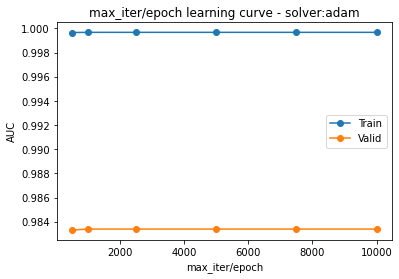

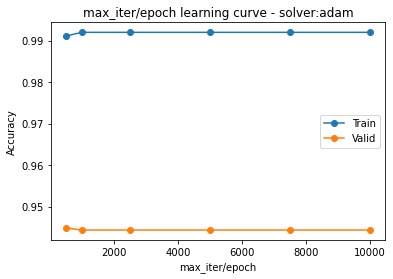

In [48]:
#learning curves

max_iters = [500,1000,2500,5000,7500,10000]
#[500,600,700,800,1000,1500,2000,3000,10000] #np.arange(1000,3001,1000)
thresh = 0.5

train_aucs = np.zeros(len(max_iters))
valid_aucs = np.zeros(len(max_iters))
train_acs = np.zeros(len(max_iters))
valid_acs = np.zeros(len(max_iters))

for jj in range(len(max_iters)):
    max_iter = max_iters[jj]
    # fit model
    t1 = time.time()
    nn=MLPClassifier(max_iter=max_iter, solver = 'adam', random_state=12)
    nn.fit(X_train_rd_tf, y_train)
    
    # get predictions
    y_train_preds = nn.predict_proba(X_train_rd_tf)[:,1]
    y_valid_preds = nn.predict_proba(X_valid_rd_tf)[:,1]

    # calculate auc
    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)
    
    accuracy_train = accuracy_score(y_train, (y_train_preds > thresh))
    accuracy_valid = accuracy_score(y_valid, (y_valid_preds > thresh))

    # save aucs
    train_aucs[jj] = auc_train
    valid_aucs[jj] = auc_valid
    
    # save accuracy
    train_acs[jj] = accuracy_train
    valid_acs[jj] = accuracy_valid
    
    t2 = time.time()
    print('max_iter:{}'.format(max_iter))
    print('Elapsed Time:',(t2-t1))
    #print('Training AUC:{:.4f}'.format(auc_train))
    #print('Validation AUC:{:.4f}'.format(auc_valid))
    #print('Training Accuracy:{:.4f}'.format(accuracy_train))
    #print('Validation Accuracy:{:.4f}'.format(accuracy_valid))
    
plt.plot(max_iters, train_aucs,'o-',label = 'Train')
plt.plot(max_iters, valid_aucs,'o-',label = 'Valid')

plt.xlabel('max_iter/epoch')
plt.title('max_iter/epoch learning curve - solver:adam')
plt.ylabel('AUC')
plt.legend()
plt.show()

plt.plot(max_iters, train_acs,'o-',label = 'Train')
plt.plot(max_iters, valid_acs,'o-',label = 'Valid')

plt.xlabel('max_iter/epoch')
plt.title('max_iter/epoch learning curve - solver:adam')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

max_iter:2000
Elapsed Time: 32.3783233165741
max_iter:2500
Elapsed Time: 25.33199119567871
max_iter:5000
Elapsed Time: 25.77020835876465
max_iter:7500
Elapsed Time: 26.45949411392212
max_iter:10000
Elapsed Time: 26.59027934074402


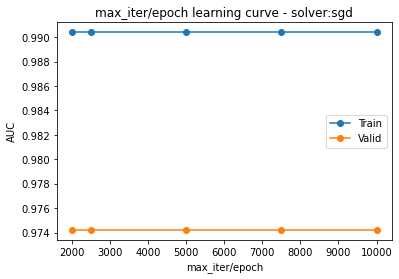

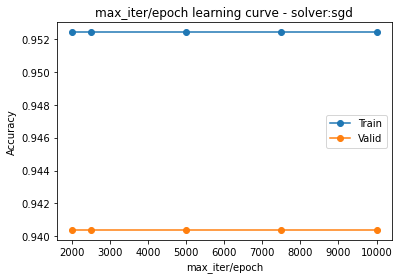

In [49]:
#learning curves

max_iters = [2000, 2500,5000,7500,10000]
#[500,600,700,800,1000,1500,2000,3000,10000] #np.arange(1000,3001,1000)
thresh = 0.5

train_aucs = np.zeros(len(max_iters))
valid_aucs = np.zeros(len(max_iters))
train_acs = np.zeros(len(max_iters))
valid_acs = np.zeros(len(max_iters))

for jj in range(len(max_iters)):
    max_iter = max_iters[jj]
    # fit model
    t1 = time.time()
    nn=MLPClassifier(max_iter=max_iter, solver = 'sgd', random_state=12)
    nn.fit(X_train_rd_tf, y_train)
    
    # get predictions
    y_train_preds = nn.predict_proba(X_train_rd_tf)[:,1]
    y_valid_preds = nn.predict_proba(X_valid_rd_tf)[:,1]

    # calculate auc
    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)
    
    accuracy_train = accuracy_score(y_train, (y_train_preds > thresh))
    accuracy_valid = accuracy_score(y_valid, (y_valid_preds > thresh))

    # save aucs
    train_aucs[jj] = auc_train
    valid_aucs[jj] = auc_valid
    
    # save accuracy
    train_acs[jj] = accuracy_train
    valid_acs[jj] = accuracy_valid
    
    t2 = time.time()
    print('max_iter:{}'.format(max_iter))
    print('Elapsed Time:',(t2-t1))
    #print('Training AUC:{:.4f}'.format(auc_train))
    #print('Validation AUC:{:.4f}'.format(auc_valid))
    #print('Training Accuracy:{:.4f}'.format(accuracy_train))
    #print('Validation Accuracy:{:.4f}'.format(accuracy_valid))
    
plt.plot(max_iters, train_aucs,'o-',label = 'Train')
plt.plot(max_iters, valid_aucs,'o-',label = 'Valid')

plt.xlabel('max_iter/epoch')
plt.title('max_iter/epoch learning curve - solver:sgd')
plt.ylabel('AUC')
plt.legend()
plt.show()

plt.plot(max_iters, train_acs,'o-',label = 'Train')
plt.plot(max_iters, valid_acs,'o-',label = 'Valid')

plt.xlabel('max_iter/epoch')
plt.title('max_iter/epoch learning curve - solver:sgd')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Hidden Layer

hidden_layer_sizes: tuple, length = n_layers - 2, default=(100,)

        The ith element represents the number of neurons in the ith hidden layer.


hidden_layer_size:1
Elapsed Time: 1.0810678005218506
Training AUC:0.7246
Validation AUC:0.7269
Training Accuracy:0.7134
Validation Accuracy:0.5072
hidden_layer_size:2
Elapsed Time: 1.8829891681671143
Training AUC:0.9236
Validation AUC:0.9066
Training Accuracy:0.8457
Validation Accuracy:0.8856
hidden_layer_size:5
Elapsed Time: 6.179480314254761
Training AUC:0.9910
Validation AUC:0.9838
Training Accuracy:0.9483
Validation Accuracy:0.9469
hidden_layer_size:10
Elapsed Time: 5.472982406616211
Training AUC:0.9967
Validation AUC:0.9866
Training Accuracy:0.9696
Validation Accuracy:0.9489
hidden_layer_size:100
Elapsed Time: 10.631845951080322
Training AUC:0.9997
Validation AUC:0.9834
Training Accuracy:0.9920
Validation Accuracy:0.9443
hidden_layer_size:150
Elapsed Time: 7.147943735122681
Training AUC:0.9992
Validation AUC:0.9853
Training Accuracy:0.9873
Validation Accuracy:0.9487
hidden_layer_size:200
Elapsed Time: 14.377928018569946
Training AUC:0.9999
Validation AUC:0.9835
Training Accuracy:0

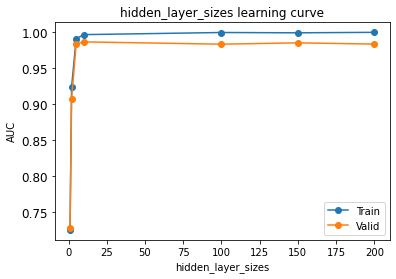

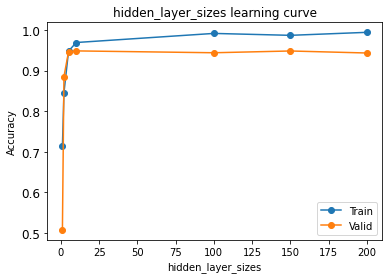

In [73]:
#learning curves

hidden_layer_sizes = [1,2,5,10,100,150,200]
#[500,600,700,800,1000,1500,2000,3000,10000] #np.arange(1000,3001,1000)
thresh = 0.5

train_aucs = np.zeros(len(hidden_layer_sizes))
valid_aucs = np.zeros(len(hidden_layer_sizes))
train_acs = np.zeros(len(hidden_layer_sizes))
valid_acs = np.zeros(len(hidden_layer_sizes))

for jj in range(len(hidden_layer_sizes)):
    hidden_layer_size = hidden_layer_sizes[jj]
    # fit model
    t1 = time.time()
    nn=MLPClassifier(hidden_layer_sizes=(hidden_layer_size,), solver = 'adam', max_iter=2000, random_state=12)
    nn.fit(X_train_rd_tf, y_train)
    
    # get predictions
    y_train_preds = nn.predict_proba(X_train_rd_tf)[:,1]
    y_valid_preds = nn.predict_proba(X_valid_rd_tf)[:,1]

    # calculate auc
    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)
    
    accuracy_train = accuracy_score(y_train, (y_train_preds > thresh))
    accuracy_valid = accuracy_score(y_valid, (y_valid_preds > thresh))

    # save aucs
    train_aucs[jj] = auc_train
    valid_aucs[jj] = auc_valid
    
    # save accuracy
    train_acs[jj] = accuracy_train
    valid_acs[jj] = accuracy_valid
    
    t2 = time.time()
    print('Hidden_layer_size:{}'.format(hidden_layer_size))
    print('Elapsed Time:',(t2-t1))
    print('Training AUC:{:.4f}'.format(auc_train))
    print('Validation AUC:{:.4f}'.format(auc_valid))
    print('Training Accuracy:{:.4f}'.format(accuracy_train))
    print('Validation Accuracy:{:.4f}'.format(accuracy_valid))
    
plt.plot(hidden_layer_sizes, train_aucs,'o-',label = 'Train')
plt.plot(hidden_layer_sizes, valid_aucs,'o-',label = 'Valid')

plt.xlabel('hidden_layer_sizes')
plt.title('hidden_layer_sizes learning curve')
plt.ylabel('AUC')
plt.legend()
plt.show()

plt.plot(hidden_layer_sizes, train_acs,'o-',label = 'Train')
plt.plot(hidden_layer_sizes, valid_acs,'o-',label = 'Valid')

plt.xlabel('hidden_layer_sizes')
plt.title('hidden_layer_sizes learning curve')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Hidden_layer_size:2
Elapsed Time: 4.710525989532471
Training AUC:0.9929
Validation AUC:0.9828
Training Accuracy:0.9669
Validation Accuracy:0.9423
Hidden_layer_size:4
Elapsed Time: 5.454553604125977
Training AUC:0.9819
Validation AUC:0.9634
Training Accuracy:0.9075
Validation Accuracy:0.9615
Hidden_layer_size:6
Elapsed Time: 5.0500807762146
Training AUC:0.9974
Validation AUC:0.9862
Training Accuracy:0.9725
Validation Accuracy:0.9486
Hidden_layer_size:8
Elapsed Time: 5.448376893997192
Training AUC:0.9977
Validation AUC:0.9884
Training Accuracy:0.9740
Validation Accuracy:0.9520
Hidden_layer_size:10
Elapsed Time: 5.247392892837524
Training AUC:0.9980
Validation AUC:0.9852
Training Accuracy:0.9758
Validation Accuracy:0.9468
Hidden_layer_size:12
Elapsed Time: 4.04500675201416
Training AUC:0.9968
Validation AUC:0.9859
Training Accuracy:0.9734
Validation Accuracy:0.9440


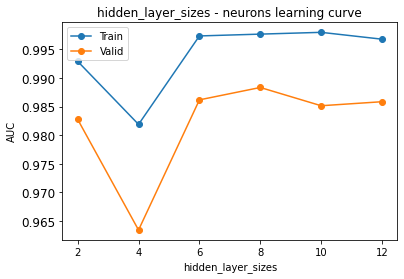

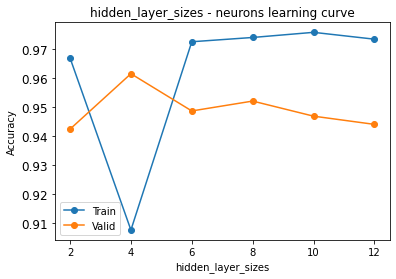

In [83]:
#learning curves

hidden_layer_sizes = [2,4,6,8,10,12]
#[500,600,700,800,1000,1500,2000,3000,10000] #np.arange(1000,3001,1000)
thresh = 0.5

train_aucs = np.zeros(len(hidden_layer_sizes))
valid_aucs = np.zeros(len(hidden_layer_sizes))
train_acs = np.zeros(len(hidden_layer_sizes))
valid_acs = np.zeros(len(hidden_layer_sizes))

for jj in range(len(hidden_layer_sizes)):
    hidden_layer_size = hidden_layer_sizes[jj]
    # fit model
    t1 = time.time()
    nn=MLPClassifier(hidden_layer_sizes=(10,hidden_layer_size), solver = 'adam', max_iter=2000, random_state=12)
    nn.fit(X_train_rd_tf, y_train)
    
    # get predictions
    y_train_preds = nn.predict_proba(X_train_rd_tf)[:,1]
    y_valid_preds = nn.predict_proba(X_valid_rd_tf)[:,1]

    # calculate auc
    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)
    
    accuracy_train = accuracy_score(y_train, (y_train_preds > thresh))
    accuracy_valid = accuracy_score(y_valid, (y_valid_preds > thresh))

    # save aucs
    train_aucs[jj] = auc_train
    valid_aucs[jj] = auc_valid
    
    # save accuracy
    train_acs[jj] = accuracy_train
    valid_acs[jj] = accuracy_valid
    
    t2 = time.time()
    print('Hidden_layer_size:{}'.format(hidden_layer_size))
    print('Elapsed Time:',(t2-t1))
    print('Training AUC:{:.4f}'.format(auc_train))
    print('Validation AUC:{:.4f}'.format(auc_valid))
    print('Training Accuracy:{:.4f}'.format(accuracy_train))
    print('Validation Accuracy:{:.4f}'.format(accuracy_valid))
    
plt.plot(hidden_layer_sizes, train_aucs,'o-',label = 'Train')
plt.plot(hidden_layer_sizes, valid_aucs,'o-',label = 'Valid')

plt.xlabel('hidden_layer_sizes')
plt.title('hidden_layer_sizes - neurons learning curve')
plt.ylabel('AUC')
plt.legend()
plt.show()

plt.plot(hidden_layer_sizes, train_acs,'o-',label = 'Train')
plt.plot(hidden_layer_sizes, valid_acs,'o-',label = 'Valid')

plt.xlabel('hidden_layer_sizes')
plt.title('hidden_layer_sizes - neurons learning curve')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [78]:
#Create Random Optimized Model

activation= ['identity', 'logistic', 'tanh', 'relu']
alpha= [0.001,0.0001,0.00001]
batch_size= ['auto']
beta_1= [0.9]
beta_2= [0.999]
early_stopping= [True,False]
epsilon= [0.00000001]
hidden_layer_sizes= [(10,4),(10,8)] #from learning curves
learning_rate= ['constant', 'invscaling', 'adaptive']
learning_rate_init= [0.01,0.001,0.0001]
max_fun= [15000]
max_iter= [5000] #from learning curve we learned that there is no improvement with additional epochs 
            #and anything less than 2500 may not converge with 'sgd' sovler. Also additional epochs do not cause model to take longer
            #[500,1000,15000]
momentum= [0.5,0.9,0.99]
n_iter_no_change= [10,50]
nesterovs_momentum= [True,False]
power_t= [0.25,0.5,0.75]
random_state= [12]
shuffle= [True,False]
solver= ['lbfgs', 'sgd', 'adam']
tol= [0.0001]
validation_fraction= [0.1]
verbose= [True]
warm_start= [True,False]

#param_rand

param_grid_nn = {'activation': activation,
 'alpha': alpha,
 'batch_size': batch_size,
 'beta_1': beta_1,
 'beta_2': beta_2,
 'early_stopping': early_stopping,
 'epsilon': epsilon,
 'hidden_layer_sizes': hidden_layer_sizes,
 'learning_rate': learning_rate,
 'learning_rate_init': learning_rate_init,
 'max_fun': max_fun,
 'max_iter': max_iter,
 'momentum': momentum,
 'n_iter_no_change': n_iter_no_change,
 'nesterovs_momentum': nesterovs_momentum,
 'power_t': power_t,
 'random_state': random_state,
 'shuffle': shuffle,
 'solver': solver,
 'tol': tol,
 'validation_fraction': validation_fraction,
 'verbose': verbose,
 'warm_start': warm_start}

print(param_grid_nn)


{'activation': ['identity', 'logistic', 'tanh', 'relu'], 'alpha': [0.001, 0.0001, 1e-05], 'batch_size': ['auto'], 'beta_1': [0.9], 'beta_2': [0.999], 'early_stopping': [True, False], 'epsilon': [1e-08], 'hidden_layer_sizes': [(10, 4), (10, 8)], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'learning_rate_init': [0.01, 0.001, 0.0001], 'max_fun': [15000], 'max_iter': [5000], 'momentum': [0.5, 0.9, 0.99], 'n_iter_no_change': [10, 50], 'nesterovs_momentum': [True, False], 'power_t': [0.25, 0.5, 0.75], 'random_state': [12], 'shuffle': [True, False], 'solver': ['lbfgs', 'sgd', 'adam'], 'tol': [0.0001], 'validation_fraction': [0.1], 'verbose': [True], 'warm_start': [True, False]}


In [79]:
# create the search cross-validation
nn_rand = RandomizedSearchCV(estimator = nn, param_distributions = param_grid_nn, 
                            n_iter=100, cv=3, scoring=auc_scoring,verbose = 1, n_jobs = -1, 
                            error_score=0)

# fit the random search model (this will take a few minutes)
t1 = time.time()
nn_rand.fit(X_train_rd_tf, y_train)
t2 = time.time()
print('Elapsed Time:',(t2-t1))


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.0min finished


Iteration 1, loss = 0.67328657
Iteration 2, loss = 0.58290730
Iteration 3, loss = 0.51443377
Iteration 4, loss = 0.46588512
Iteration 5, loss = 0.43108362
Iteration 6, loss = 0.40602037
Iteration 7, loss = 0.38736462
Iteration 8, loss = 0.37259609
Iteration 9, loss = 0.36001782
Iteration 10, loss = 0.34977169
Iteration 11, loss = 0.34036335
Iteration 12, loss = 0.33240415
Iteration 13, loss = 0.32522546
Iteration 14, loss = 0.31883504
Iteration 15, loss = 0.31329362
Iteration 16, loss = 0.30839326
Iteration 17, loss = 0.30387064
Iteration 18, loss = 0.29996857
Iteration 19, loss = 0.29590239
Iteration 20, loss = 0.29260616
Iteration 21, loss = 0.28940137
Iteration 22, loss = 0.28658429
Iteration 23, loss = 0.28364721
Iteration 24, loss = 0.28114674
Iteration 25, loss = 0.27892755
Iteration 26, loss = 0.27648873
Iteration 27, loss = 0.27407357
Iteration 28, loss = 0.27220929
Iteration 29, loss = 0.27017444
Iteration 30, loss = 0.26841586
Iteration 31, loss = 0.26670137
Iteration 32, los

Iteration 278, loss = 0.08580972
Iteration 279, loss = 0.08252788
Iteration 280, loss = 0.08567888
Iteration 281, loss = 0.08557002
Iteration 282, loss = 0.08483890
Iteration 283, loss = 0.08251079
Iteration 284, loss = 0.08271005
Iteration 285, loss = 0.08219770
Iteration 286, loss = 0.08169102
Iteration 287, loss = 0.08325214
Iteration 288, loss = 0.08395629
Iteration 289, loss = 0.08300452
Iteration 290, loss = 0.08177449
Iteration 291, loss = 0.08106712
Iteration 292, loss = 0.08083501
Iteration 293, loss = 0.08248039
Iteration 294, loss = 0.08300229
Iteration 295, loss = 0.08195243
Iteration 296, loss = 0.08267299
Iteration 297, loss = 0.08231412
Iteration 298, loss = 0.08020435
Iteration 299, loss = 0.08055000
Iteration 300, loss = 0.08153702
Iteration 301, loss = 0.08330310
Iteration 302, loss = 0.08128325
Iteration 303, loss = 0.08004863
Iteration 304, loss = 0.08067945
Iteration 305, loss = 0.08208701
Iteration 306, loss = 0.07992936
Iteration 307, loss = 0.07957806
Iteration 

In [80]:
print(nn_rand.best_params_)

print('Optimized Neural Network')
y_train_preds_rand = nn_rand.best_estimator_.predict_proba(X_train_rd_tf)[:,1]
y_valid_preds_rand = nn_rand.best_estimator_.predict_proba(X_valid_rd_tf)[:,1]

nn_train_opt_auc = roc_auc_score(y_train, y_train_preds_rand)
nn_valid_opt_auc = roc_auc_score(y_valid, y_valid_preds_rand)

print('Training AUC:{:.3f}'.format(nn_train_opt_auc))
print('Validation AUC:{:.3f}'.format(nn_valid_opt_auc))

{'warm_start': False, 'verbose': True, 'validation_fraction': 0.1, 'tol': 0.0001, 'solver': 'sgd', 'shuffle': True, 'random_state': 12, 'power_t': 0.25, 'nesterovs_momentum': False, 'n_iter_no_change': 10, 'momentum': 0.9, 'max_iter': 5000, 'max_fun': 15000, 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (10, 8), 'epsilon': 1e-08, 'early_stopping': False, 'beta_2': 0.999, 'beta_1': 0.9, 'batch_size': 'auto', 'alpha': 0.0001, 'activation': 'tanh'}
Optimized Neural Network
Training AUC:0.997
Validation AUC:0.986


### TensorFlow
(Using example from discussion T13_tutorial_deep_learning_basics

In [53]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Commonly used modules
import numpy as np
import os
import sys

In [67]:
def build_model():
    model = keras.Sequential([
        Dense(20, activation=tf.nn.relu, input_shape=[len(X_train_rd_tf[0])]),
        Dense(1)
    ])

    model.compile(optimizer=tf.optimizers.Adam(), 
                  loss='mse',
                  #metrics=[tf.keras.metrics.AUC()]
                  metrics=[tf.keras.metrics.BinaryAccuracy(),'mae', 'mse']
                 )
    return model

In [68]:
# this helps makes our output less verbose but still shows progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

model = build_model()

In [69]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(X_train_rd_tf, y_train, epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch




.............................................................................................

In [70]:
hist.describe()

,loss,binary_accuracy,mae,mse,val_loss,val_binary_accuracy,val_mae,val_mse,epoch
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,0.070243,0.926663,0.183746,0.070243,0.089486,0.904685,0.224273,0.089486,46.000000
std,0.065980,0.058043,0.062049,0.065980,0.035838,0.042343,0.042042,0.035838,26.990739
min,0.044983,0.577668,0.145082,0.044983,0.065708,0.622419,0.186371,0.065708,0.000000
25%,0.047644,0.921839,0.152084,0.047644,0.076869,0.908555,0.203582,0.076869,23.000000
50%,0.051813,0.951396,0.160808,0.051813,0.081830,0.914454,0.212487,0.081830,46.000000
75%,0.069066,0.956322,0.191204,0.069066,0.088276,0.920354,0.227068,0.088276,69.000000
max,0.634511,0.960591,0.611382,0.634511,0.376953,0.943953,0.491287,0.376953,92.000000


In [58]:
rmse_final = np.sqrt(float(hist['val_mse'].tail(1)))
print()
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))


Final Root Mean Square Error on validation set: 0.277


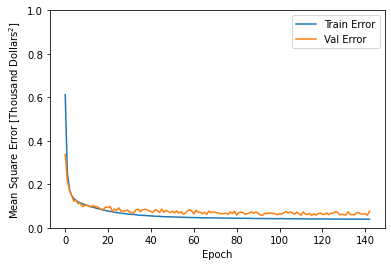

In [59]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [Thousand Dollars$^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()
    plt.ylim([0,1])

plot_history()

In [62]:
mse, _, _, _ = model.evaluate(X_test_rd_tf, y_test)
model.evaluate(X_test_rd_tf, y_test)
rmse = np.sqrt(mse)
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

2171/2171 [==============================] - 1s 439us/step - loss: 0.0790 - accuracy: 0.0000e+00 - mae: 0.1913 - mse: 0.0790
Root Mean Square Error on test set: 0.281


# Compare Models  NN vs LogReg

In [63]:
y_train_preds_lr = lr_grid.best_estimator_.predict_proba(X_train_rd_tf)[:,1]
y_valid_preds_lr = lr_grid.best_estimator_.predict_proba(X_valid_rd_tf)[:,1]
y_test_preds_lr = lr_grid.best_estimator_.predict_proba(X_test_rd_tf)[:,1]

y_train_preds_nn = nn_rand.best_estimator_.predict_proba(X_train_rd_tf)[:,1]
y_valid_preds_nn = nn_rand.best_estimator_.predict_proba(X_valid_rd_tf)[:,1]
y_test_preds_nn = nn_rand.best_estimator_.predict_proba(X_test_rd_tf)[:,1]

In [64]:
thresh = 0.5

print('LR Training:')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = cc.print_report(y_train,y_train_preds_lr, thresh)
print('LR Validation:')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = cc.print_report(y_valid,y_valid_preds_lr, thresh)
print('LR Test:')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = cc.print_report(y_test,y_test_preds_lr, thresh)

print('NN Training:')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = cc.print_report(y_train,y_train_preds_nn, thresh)
print('NN Validation:')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = cc.print_report(y_valid,y_valid_preds_nn, thresh)
print('NN Test:')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = cc.print_report(y_test,y_test_preds_nn, thresh)


LR Training:
AUC:0.840
accuracy:0.864
recall:0.748
precision:0.974
specificity:0.980
prevalence:0.500
 
LR Validation:
AUC:0.805
accuracy:0.971
recall:0.711
precision:0.112
specificity:0.972
prevalence:0.005
 
LR Test:
AUC:0.840
accuracy:0.971
recall:0.762
precision:0.121
specificity:0.972
prevalence:0.005
 
NN Training:
AUC:1.000
accuracy:1.000
recall:1.000
precision:1.000
specificity:1.000
prevalence:0.500
 
NN Validation:
AUC:0.983
accuracy:0.948
recall:0.942
precision:0.083
specificity:0.948
prevalence:0.005
 
NN Test:
AUC:0.987
accuracy:0.949
recall:0.942
precision:0.085
specificity:0.949
prevalence:0.005
 


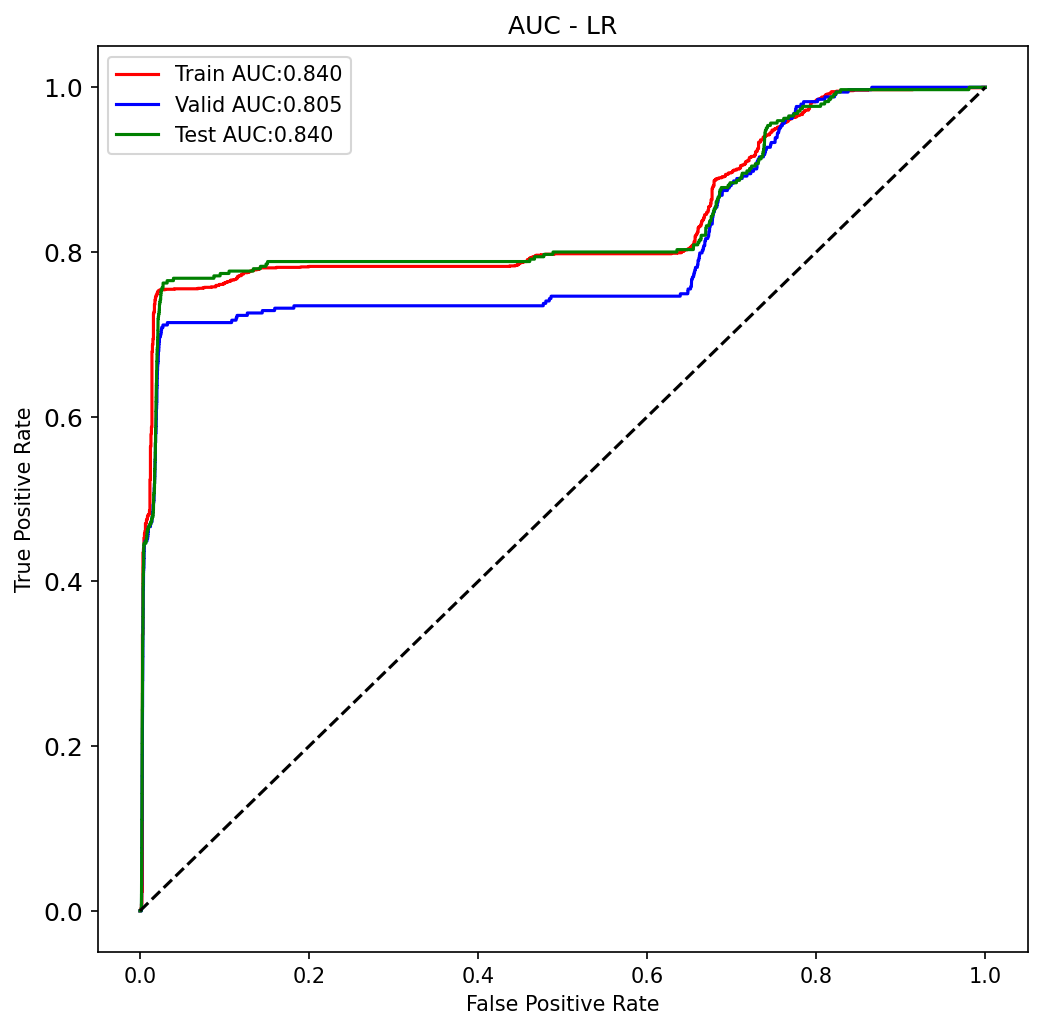

In [65]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds_lr)
auc_train = roc_auc_score(y_train, y_train_preds_lr)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds_lr)
auc_valid = roc_auc_score(y_valid, y_valid_preds_lr)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds_lr)
auc_test = roc_auc_score(y_test, y_test_preds_lr)



plt.figure(figsize=(8,8), dpi=150)
plt.rc('ytick', labelsize=12) 
plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:{:.3f}'.format(auc_train))
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:{:.3f}'.format(auc_valid))
plt.plot(fpr_test, tpr_test, 'g-',label ='Test AUC:{:.3f}'.format(auc_test))
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC - LR')
plt.legend()
plt.show()

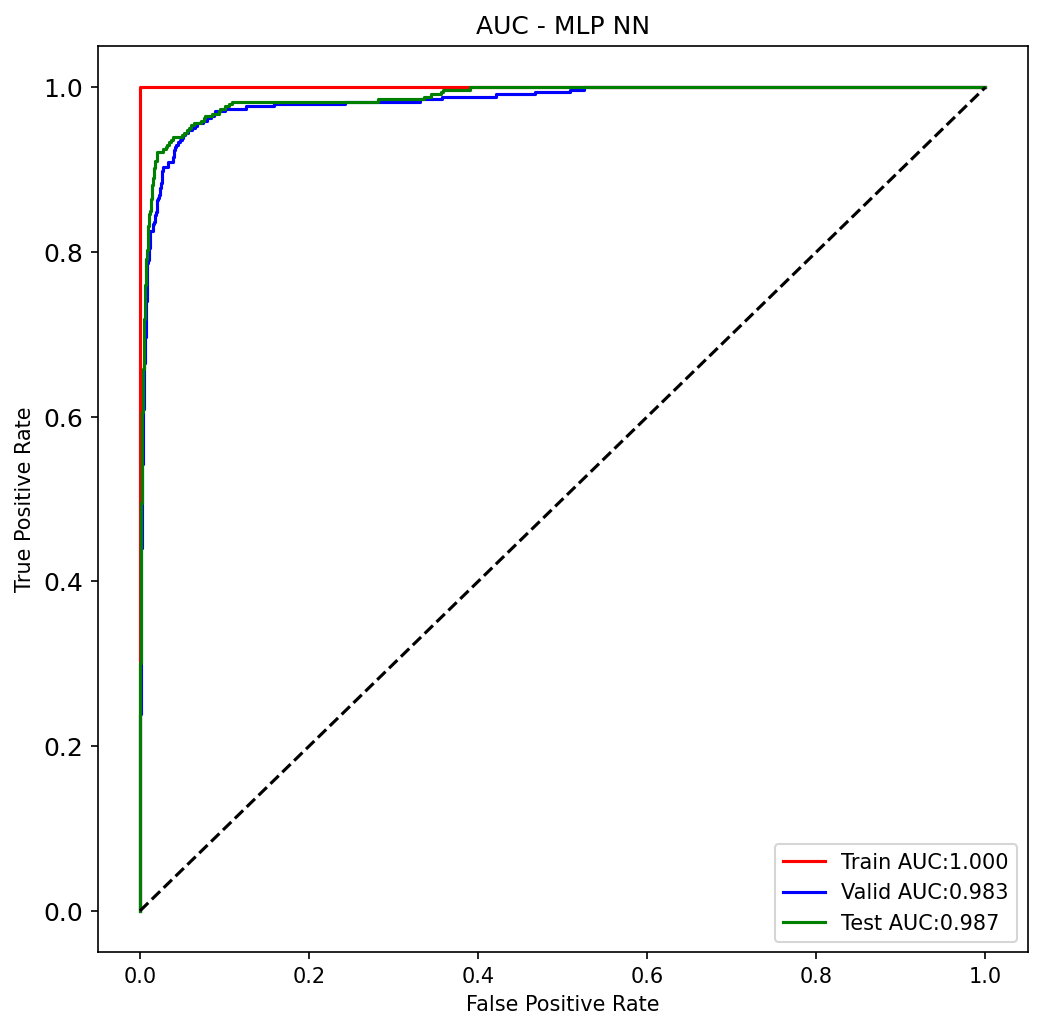

In [81]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds_nn)
auc_train = roc_auc_score(y_train, y_train_preds_nn)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds_nn)
auc_valid = roc_auc_score(y_valid, y_valid_preds_nn)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds_nn)
auc_test = roc_auc_score(y_test, y_test_preds_nn)



plt.figure(figsize=(8,8), dpi=150)
plt.rc('ytick', labelsize=12) 
plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:{:.3f}'.format(auc_train))
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:{:.3f}'.format(auc_valid))
plt.plot(fpr_test, tpr_test, 'g-',label ='Test AUC:{:.3f}'.format(auc_test))
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC - MLP NN')
plt.legend()
plt.show()